In [1]:
# test code in `scripts/training/yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/master_with_cb19.py`

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

X_train (9760, 1, 50, 50)
118.1267
114.90781


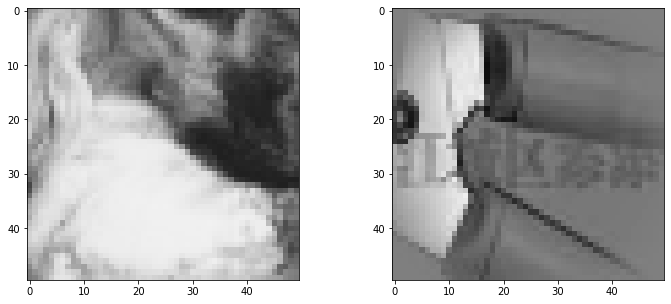

y_train (9760, 194)
0.4998246687287248 0.004637062226926978


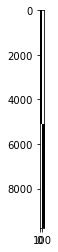

X_val (2440, 1, 50, 50)
119.57259
115.02277


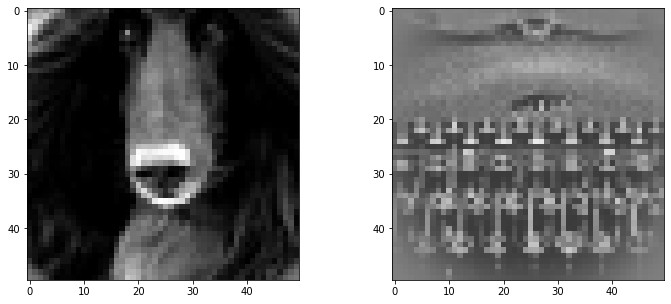

y_val (2440, 194)
0.49757314069145586 0.01531187032210357


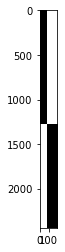

X_test (3050, 1, 50, 50)
118.7617
114.808495


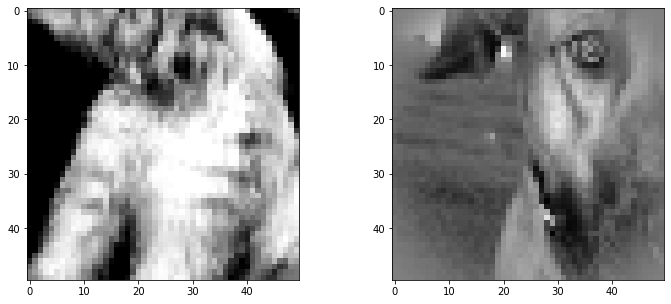

y_test (3050, 194)
0.501440071075172 0.013305585015176997


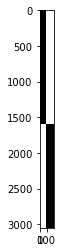

In [3]:
from typing import Optional

import numpy as np

from thesis_v2.data.prepared import combine_two_separate_datasets
from thesis_v2.data.prepared.cadena_plos_cb19 import get_data as get_data_cb19, global_dict
from thesis_v2.data.prepared.yuanyuan_8k import get_data, get_data_per_trial, flatten_per_trial_data_one

from thesis_v2.training_extra.maskcnn_like.opt import get_maskcnn_v1_opt_config
from thesis_v2.training_extra.maskcnn_like.training import (train_one,
                                                            partial)

from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import (
    gen_maskcnn_polished_with_rcnn_k_bl, load_modules
)

from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    keygen, decode_transfer_learning_cb19_params
)

two_data_ratio = (8000//50, global_dict['num_img']//50)

load_modules()


def check_good_data(data_this):
    print(np.nanmean(data_this, axis=0).mean(),np.nanmean(data_this, axis=0).std())
    
    n1, n2 = data_this.shape
    assert n2==79+115
#     print(n1)
    n11 = n1//sum(two_data_ratio)*two_data_ratio[0]
    n12 = n1//sum(two_data_ratio)*two_data_ratio[1]
    assert n11 + n12 == n1
    assert np.all(np.isfinite(data_this[:n11, :79]))
    assert np.all(np.isnan(data_this[:n11, 79:]))
    
    assert np.all(np.isnan(data_this[n11:, :79]))
    assert np.all(np.isfinite(data_this[n11:, 79:]))
    
    plt.close('all')
    plt.figure()
    plt.imshow(np.isnan(data_this), cmap='gray')
    plt.show()
    
    
def check_select_images(data_this):
    n1, c, h, w = data_this.shape
    assert c == 1
    assert h == 50
    assert w == 50
    n11 = n1//sum(two_data_ratio)*two_data_ratio[0]
    n12 = n1//sum(two_data_ratio)*two_data_ratio[1]
    assert n11 + n12 == n1
    assert np.all(np.isfinite(data_this))
    print(data_this[:n11].mean())
    print(data_this[n11:].mean())
    
    plt.close('all')
    fig, axes = plt.subplots(1,2,figsize=(12, 5), squeeze=True)
    axes[0].imshow(data_this[n11-1,0], cmap='gray', vmin=0, vmax=255)
    axes[1].imshow(data_this[n11,0], cmap='gray', vmin=0, vmax=255)
    plt.show()
    

def get_cb19_data(*, px_kept, input_size, split_seed, seq_length, train_keep):
    if seq_length is None:
        # keeping mean response at 0.5 seems the best. somehow. using batch norm is bad, somehow.
        datasets = get_data_cb19(px_kept=px_kept, final_size=input_size, seed=split_seed, scale=0.5, force_resize=True)
    else:
        raise ValueError

    trainset_full_size = global_dict['num_img'] // 5 * 4 // 5 * 4

    if train_keep is not None:
        if train_keep == 'full':
            train_keep = trainset_full_size
        elif train_keep == 'half':
            train_keep = trainset_full_size // 2
        elif train_keep == 'quarter':
            train_keep = trainset_full_size // 4
        else:
            raise ValueError
        train_keep_slice = slice(train_keep)
    else:
        raise ValueError

    datasets = {
        'X_train': datasets[0][train_keep_slice].astype(np.float32),
        'y_train': datasets[1][train_keep_slice],
        'X_val': datasets[2].astype(np.float32),
        'y_val': datasets[3],
        'X_test': datasets[4].astype(np.float32),
        'y_test': datasets[5],
    }

    return datasets

def get_combined_data(*,
                      input_size, additional_key, split_seed, seq_length=None, train_keep):
    cb19_decoded = decode_transfer_learning_cb19_params(
        additional_key=additional_key
    )

    if seq_length is None:
        # keeping mean response at 0.5 seems the best. somehow. using batch norm is bad, somehow.
        datasets = get_data('a', 200, input_size, ('042318', '043018', '051018'), scale=0.5,
                            seed=split_seed)
    else:
        datasets = get_data_per_trial('a', 200, input_size, ('042318', '043018', '051018'),
                                      scale=0.5, seed=split_seed, previous_k_frames=seq_length - 1)
        # then flatten it.
        datasets = tuple(
            [
                flatten_per_trial_data_one(zz) for zz in datasets
            ]
        )

    # get cb19 data. do this early because later on train_keep will be modified.
    datasets_cb19 = get_cb19_data(px_kept=cb19_decoded['cb19_px_kept'],
                                  input_size=input_size,
                                  split_seed=cb19_decoded['cb19_split_seed'],
                                  seq_length=seq_length, train_keep=train_keep)


    trainset_full_size = 8000 // 5 * 4 // 5 * 4
    if train_keep is not None:
        if train_keep == 'full':
            train_keep = trainset_full_size
        elif train_keep == 'half':
            train_keep = trainset_full_size // 2
        elif train_keep == 'quarter':
            train_keep = trainset_full_size // 4
        else:
            raise ValueError
        train_keep_slice = slice(train_keep)
    else:
        raise ValueError

    datasets = {
        'X_train': datasets[0][train_keep_slice].astype(np.float32),
        'y_train': datasets[1][train_keep_slice],
        'X_val': datasets[2].astype(np.float32),
        'y_val': datasets[3],
        'X_test': datasets[4].astype(np.float32),
        'y_test': datasets[5],
    }



    # combine the two
    assert datasets_cb19.keys() == datasets.keys()
    datasets_combined = dict()
    for zzz in ['train', 'val', 'test']:
        datasets_combined[f'X_{zzz}'], datasets_combined[f'y_{zzz}'] = combine_two_separate_datasets(
            x1=datasets[f'X_{zzz}'], y1=datasets[f'y_{zzz}'],
            x2=datasets_cb19[f'X_{zzz}'], y2=datasets_cb19[f'y_{zzz}']
        )

    for idx, z in enumerate(datasets_combined):
        print(z, datasets_combined[z].shape)
        
        if idx % 2 != 0:
            check_good_data(datasets_combined[z])
            
        else:
            check_select_images(datasets_combined[z])
    
    return datasets_combined


combined_data = get_combined_data(
    additional_key='cb19_px100_ss0', input_size=50, split_seed='legacy',train_keep='full'
)

